# Score-based generative models (SGM)

Now let's apply what we've learned about `Jax` and Langevin dynamics to SGM

## How Score-based generative models work?
Given access to samples $\{x_i\}$ from a target distribution with *unknown* density $\mu_\text{data}$, generative models seek to learn the underlying distribution and generate more samples from $\mu_\text{data}$. As usual, we will sample from an easy to sample distribution and we will transform such samples that will correspond to samples of the target distribution.

### Forward SDE
Score-based generative models (SGM) do this by employing two stochastic differential equations (SDEs). The first one is called the **forward SDE**.

Recall that under a few regularite assumptions, any SDE of the form
$$\begin{array}{rcl}
        \mathrm{d}X_t & = & f(X_t,t)\mathrm{d}t + g(t)\mathrm{d}W_t \\
        X_0 & \sim & \mu_\text{data}.
\end{array}
$$
with *drift coefficient* $f$ and *diffusion coefficient* $g$ has a corresponding Fokker-Planck equation given by
$$\partial_{t}p(x,t) = \nabla_{x}\cdot(f(x,t)p(x,t)) + \frac{1}{2}g(t)^{2}\Delta_{x} p(x,t).$$

From now on let $p_{t}(x) := p(x,t)$ and we note that $p_{0} = \mu_{\text{data}}$. We suppose that we run this SDE until a terminal time $T$.
### Reverse SDE
The previous SDE has the following **reverse-time SDE**
$$\begin{array}{rcl}
        \mathrm{d}Y_t & = & [f(Y_t,t) + g(t)^2\nabla \log{p_t(Y_t)}]\mathrm{d}t + g(t)\mathrm{d}W_t\\
        Y_0 & \sim & q_0
\end{array}$$
where $Y_t = X_{T-t}$, $q_t = p_{T-t}$ so $q_0 = p_T$. If we know $p_T$ then we could run the reverse SDE and generate samples from $q_T = \mu_{\text{data}}$. Still knowing $p_{T}$ might not be as simple as it looks.

### The problems
We cannot access the marginals $p_t$ of the forward SDE, since we do not know $p_0 = \mu_\text{data}$. This leads to the following two problems.

1. We do not have access to $p_T$, the initial condition of the the reverse SDE,
2. For the same reason we do not know $p_{t}$ and therefore the drift $\nabla \log p_{T-t}$ of the reverse SDE.

We may solve the previous problems if we our forward SDE has some nice properties. For instance, if the probability densities of our forward SDE converge to $\mathcal{N}(0, I)$ at an exponential speed, i.e., $p_t \to \mathcal{N}(0, I)$, independently of $p_0$. Therefore, we can start the reverse SDE in $q_0 = \mathcal{N}(0, I) \approx p_T$. Then we could train a neural network approximation $s_\theta(x, t) \approx \nabla \log p_{t}(x)$ using score matching.

## How de we train the model?

In the previous notebook we learn how to use Langevin dynamics to draw samples from a target distribution. But, in those examples we knew the target distribution so we didn't have to train the score function. In this notebook we will try to estimate the score function that we will use by running the reverse SDE given some empirical measure that will give us the score or by training a neural network to obtain the score.

In [1]:
import jax.numpy as jnp
import jax
from jax.experimental.host_callback import id_print
import matplotlib.pyplot as plt
from jax.lax import scan
from jax import grad, jit, vmap
import jax.random as random
from functools import partial
rng = random.PRNGKey(2023)

from typing import Callable, Union

# Generating Samples from $\mu_\text{data}$
The first thing we will do is generate samples from some target manifolds. These will be used as training data. We will generate $J$ samples.

In [2]:
def sample_sphere(J: int) -> jax.Array:
    """
    2 dimensional sample
    
    N_samples: Number of samples
    Returns a (N_samples, 2) array of samples
    """
    alphas = jnp.linspace(0, 2*jnp.pi * (1 - 1/J), J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    mf = jnp.stack([xs, ys], axis=1)
    return mf

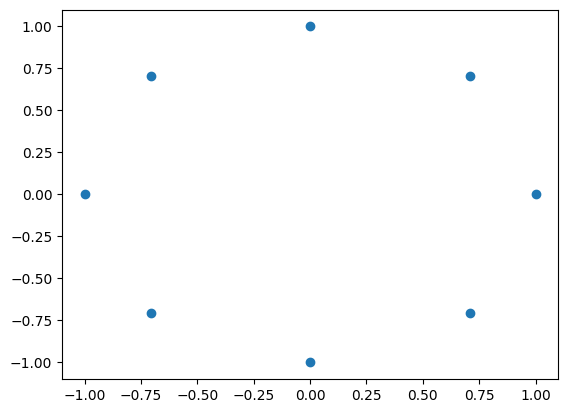

In [3]:
J = 8
mf = sample_sphere(J)
plt.scatter(mf[:, 0], mf[:, 1])
plt.show()

## The forward SDE
### Ornstein-Uhlenbeck process (OU process)
For the forward SDE we will use the Ornstein-Uhlenbeck process for simplicity, due to its simple form (in particular, since the drift and dispersion are linear), we do not actually need to run it to generate samples from it (for a more complicated process one has to first run the forward ODE to generate the samples). We can actually evaluate the transition densities in a closed form, and they are given by a normal distribution:

$$p^O_{t|0}(x_t | x_0) = \mathcal{N}\left(\exp(-\frac{1}{2}t) x_0, (1 - \exp(-t))I\right)$$

### Time-changed OU process
For numerical reasons it is often useful to change the time, i.e. instead treat
$$dX_t = -\frac{1}{2}\beta_t X_t + \sqrt{\beta_t} dB_t$$
We define $\alpha_t = \int_0^t \beta_s \mathrm{d}s$. Then the __transition kernel__ of $X_t$ is given as 
$$p_{t|0}(x_t | x_0) = \mathcal{N}(m_t x_0, v_t I),$$ 
where

| | |
|---|---|
| $m_t$  | $\exp(-\frac{1}{2}\alpha_t)$ |
| $v_t$  | $1 - \exp(-\alpha_t)$ |.

We directly will implement the OU-SDE with the time-change parameters $\alpha_t$ and $\beta_t$ since they greatly impact the performance.

In particular we will employ the function
$$\beta_t = \beta_\text{min} + t(\beta_\text{max} - \beta_\text{min}).$$
In this case we get
$$\alpha_t = t \beta_\text{min} + \frac{1}{2} t^2 (\beta_\text{max} - \beta_\text{min}).$$
This choice of $\beta_t$ is popular in practice.

You can later play around with different choices of $\beta_t$ and $\alpha_t$ or use the above proposals and play around with $\beta_\text{min}$ and $\beta_\text{max}$. Good default values for $\beta_\text{min}$ and $\beta_\text{max}$ are
$$\beta_\text{min} = 0.001, \beta_\text{max} = 3.$$

Given the latter we define the following functions.

In [4]:
beta_min = 0.001
beta_max = 3

def beta_t(t: jax.Array) -> jax.Array:
    """
    t: time (number)
    returns beta_t as explained above
    """
    return beta_min + t*(beta_max - beta_min)

def alpha_t(t: jax.Array) -> jax.Array:
    """
    t: time (number)
    returns alpha_t as explained above
    """
    return t*beta_min + 0.5 * t**2 * (beta_max - beta_min)

def drift(x: jax.Array, t: jax.Array) -> jax.Array:
    """
    x: location of J particles in N dimensions, shape (J, N)
    t: time (number)
    returns the drift of a time-changed OU-process for each batch member, shape (J, N)
    """
    return -0.5*beta_t(t)*x

def dispersion(t: jax.Array) -> jax.Array:
    """
    t: time (number)
    returns the dispersion
    """
    return jnp.sqrt(beta_t(t))

def mean_factor(t: jax.Array) -> jax.Array:
    """
    t: time (number)
    returns m_t as above
    """
    return jnp.exp(-0.5 * alpha_t(t))

def var(t: jax.Array) -> jax.Array:
    """
    t: time (number)
    returns v_t as above
    """
    return 1 - jnp.exp(-alpha_t(t))

### Marginals of the time-changed OU-process
We have seen above that the time-$t$ transition kernel is given as
$$p(x_t | x_0) = \mathcal{N}(m_t x_0, v_t I).$$ 

We now assume that we have $J$ samples $\{x^j\}_{j=1}^J$ from our target distribution $\mu_\text{data}$. The empirical measure
$$\hat{\mu}_\text{data} = \frac{1}{J} \sum_{j=1}^J \delta_{x^j}$$
is then an approximation to $\mu_\text{data}$. If we start the forward SDE in $p_0 = \hat{\mu}_\text{data}$, we get marginals $\hat{p}_t$,
$$\hat{p}_t(x_t) = \frac{1}{J} \sum_{j=1}^J p_{t|0}(x_t | x^j),$$
which is nothing more than a Gaussian mixture with $J$ components, one for each sample $x^j$. The components are centred at $m_t x^j$ and have variance $v_t$. These empirical marginals we can evaluate (as opposed to the unknown $p_t$). Therefore we can also actually write down the empirical drift $\nabla \log \hat{p}_t$ (all though every evaluation of it needs to access the whole training set!).

In [5]:
from jax.scipy.special import logsumexp

def log_hat_pt(x: jax.Array, t: jax.Array) -> Callable[[jax.Array, jax.Array], jax.Array]:
    """
    x: One location in R^n
    t: time (number)
    returns the log density log \hat{p}_t(x) as described above
    
    """
    N = mf.shape[0]
    means = mf * mean_factor(t)
    v = var(t)
    potentials = jnp.sum(-(x - means)**2 / (2 * v), axis=1)
    # this is equivalent to
    # return jnp.log(1/N * jnp.sum(jnp.exp(potentials)))
    # but is numerically more stable
    return logsumexp(potentials, axis=0, b=1/N)

nabla_log_hat_pt = jit(vmap(grad(log_hat_pt), in_axes=(0, 0), out_axes=(0)))

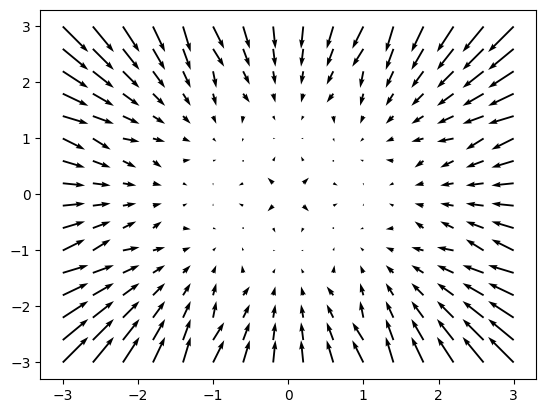

In [6]:
def plot_score(score: Callable[[jax.Array], jax.Array],
               t: jax.Array, area_min: Union[int,float]=-1,
               area_max: Union[int,float]=1) -> None:
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y = jnp.meshgrid(x, x)
        grid = jnp.stack([x.flatten(), y.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    plt.quiver(grid[:, 0], grid[:, 1], scores[:, 0], scores[:, 1])

plot_score(nabla_log_hat_pt, 0.01, -3, 3)

## Implementing the reverse SDE
Now comes the most complicated part. Implement the reverse SDE. The function signature is given below. In JAX you cannot use `for`-loops, but need to replace them by other similar functions. The outer JAX-construct is already filled in and you only need to fill in the loop body. For the time-changed OU process the reverse SDE is given by

$$dY_t = \frac{1}{2}\beta_{1-t} Y_t + \beta_{1-t} \nabla \log p_{1-t}(Y_t) + \sqrt{\beta_{1-t}} \mathrm{d}B_t.$$

### Intuition
We give a short intuitive explanation on why this SDE can be interpreted as running the above SDE backwards note that we are doing 2 things: 
Firstly, the drift and Brownian motion is multiplied by $-1$ to reverse the time direction. The $-1$ in front of the Brownian motion vanishes, since the Brownian Motion increments are symmetric noise and -$\mathrm{d}B_t$ has the same distribution as $\mathrm{d}B_t$.

Secondly, the term $\sqrt{\beta_t}\mathrm{d}B_t$ in the forward SDE induces the paths to "spread out" (diffuse). The same thing happens with the reverse SDE, since it also has the $\sqrt{\beta_t} \mathrm{d}B_t$. But in the reverse direction we want $Y_t$ to start in a diffused distribution ($\mathcal{N}(0, I)$) and then concentrate towards a not-diffused distribution $p_0$. Therefore the $\beta_t \nabla \log p_t(x)$ term counteracts the diffusion, by forcing the $Y_t$ particles to high probability areas of $X_t$.

### Implementation
The reverse SDE is implemented using the Euler-Maryuama scheme. To advance the SDE by $\delta t$, we implement the following iteration,
$$Y_{t_{i+1}} = Y_{t_i} + (t_{i+1} - t_i) \left(\frac{1}{2} \beta_{1-t} Y_{t} + \beta_{1-t} \nabla \log p_{1-t}(Y_t)\right) + \sqrt{\beta_{1-t}} Z_{t_{i+1} - t_i},$$
where $Z_{t_{i+1} - t_i}$ is a random variable with distribution 
$$Z_{t_{i+1} - t_i} \sim \mathcal{N}(0, Z_{t_{i+1} - t_i} I).$$
We will always run the foward SDE until time $1$. Therefore the time interval for the backward SDE is also $[0, 1]$. We discretize this time interval into discrete times $(t_i)_{i=1}^R$, $t_0 = 0, t_R = 1$ and run the above scheme. 

For this we can use what we learned about Langevin dynamics and use the LMC or MALA algorithms. For simplicity, we will use the LMC algorithm here.

Also, note that in this case we have a time dependence in our SDE.

In [7]:
R = 1000
train_ts = jnp.arange(1, R)/(R-1)


@partial(jax.jit, static_argnums=(1,2,3,4,5))
def lmc_sampler(key:jax.Array,
                grad_log: Callable[[jax.Array], jax.Array],
                dispersion: Callable[[jax.Array], jax.Array],
                forward_drift: Callable[[jax.Array, jax.Array], jax.Array],
                N: int, n_samples: int,
                ts: jax.Array=train_ts) -> jax.Array:
    """
    LMC sampler

    Args:
        key: random number generator
        grad_log: drift term for the SDE (here the score)
        N: dimension of the problem
        dt: time step
        x_0: initial point
    """
    def lmc_step_with_kernel(carry, params_time):
        key, x = carry
        t, dt = params_time
        key, subkey = jax.random.split(key)
        # Now we run the kernel using Euler-Maruyama
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + grad_log(x, 1-t)*disp**2
        x = x + dt*drift + jnp.sqrt(dt)*disp*random.normal(key=subkey, shape=(x.shape))
        return (key, x), ()
    key, subkey = random.split(key)
    dts = ts[1:] - ts[:-1]
    params_time = jnp.stack([ts[:-1], dts], axis=1)
    x_0 = random.normal(subkey, shape=(n_samples, N))
    carry = (key, x_0)
    (_, samples), _ = scan(lmc_step_with_kernel, carry, params_time)
    return samples

In [8]:
def plot_heatmap(positions: jax.Array,
                 area_min: Union[int, float]=-2,
                 area_max: Union[int, float]=2) -> None:
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate
    
    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y = jnp.meshgrid(a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    extent = [area_min, area_max, area_max, area_min]
    plt.imshow(hm, cmap="coolwarm",interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()

## Running the reverse SDE with the empirical drift
We can now plug in the empirical drift $\nabla \log \hat{p}_t$ into the reverse SDE and run it with it. It is then the _exact_ reverse SDE for the data distribution $p_0 = \hat{\mu}_\text{data}$.
We see that we also exactly recover $\hat{\mu}_\text{data}$.

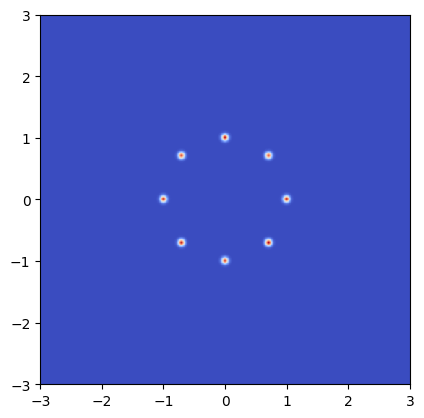

In [9]:
rng, step_rng = random.split(rng)
samples = lmc_sampler(step_rng, nabla_log_hat_pt, dispersion, drift, 2, 5000)
plot_heatmap(samples[:, [0,1]], -3, 3)

## Bounded perturbation of the score
We will now add a bounded perturbation the empirical score. We see that the sample distribution is now not $\mu_\text{data}$ anymore. But the error does not change the support of the distribution, it only changes the distribution on the support. In particular, the sample distribution will only output training examples, just in a different frequency:

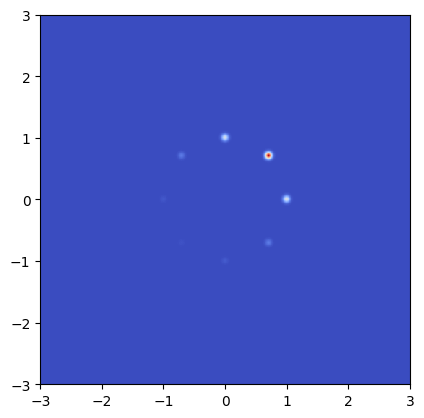

In [10]:
perturbed_score = lambda x, t: nabla_log_hat_pt(x, t) + 1
rng, step_rng = random.split(rng)
samples = lmc_sampler(step_rng, perturbed_score, dispersion, drift, 2, 5000)
plot_heatmap(samples[:, [0,1]], -3, 3)

## Neural Network Training

### The loss
Up to now we used the exact drifts $\nabla \log \hat{p}_t$ in our algorithm. These are the exact marginals of $X_t$ if $X_0$ is started in $p_0 = \hat{\mu}_\text{data} = \frac{1}{J} \sum_{j=1}^J \delta_{x^j}$. 
We again denote the distribution of $X_t$ by $p_t$ if $X_0$ is started in $p_0 = \mu_\text{data}$. Note that these are inaccessible, since we do not actually know $\mu_\text{data}$. 

Instead of using the exact drifts, we will now train a Neural Network to approximate $\nabla \log \hat{p}_t$. We do this by so-called Score-Matching Techniques. The optimal loss we would like to minimize is

$$L(\theta, t) = \mathbb{E}_{x \sim p_t(x)}[\| \nabla \log p_t(x) - s_\theta(x, t)\|^2] = \mathbb{E}_{x_0 \sim \mu_\text{data}}\mathbb{E}_{x \sim p_{t,0}(x | x_0)}[\| \nabla \log p_t(x) - s_\theta(x, t)\|^2]$$
which we cannot do since we do not know $\mu_\text{data}$ / cannot generate arbitrary new samples from it (if we could, we could just use these samples and would not need a SGM).

Instead, we use the following replacement loss:
$$\hat{L}(\theta, t) = \mathbb{E}_{x \sim \hat{p}_t(x)}[\| \nabla \log \hat{p}_t(x) - s_\theta(x, t)\|^2] = \mathbb{E}_{x_0 \sim \hat{\mu}_\text{data}}\mathbb{E}_{x \sim p_{t,0}(x | x_0)}[\| \nabla \log \hat{p}_t(x) - s_\theta(x, t)\|^2],$$
which can be explicitly evaluated. 

### Remark: A short intermezzo on generalization/memorization in SGMs
As we have seen above (and also proven in [0]), if $|s_\theta(x, t) - \nabla \log \hat{p}_t(x)|$ is bounded, then the SGM will actually output a distribution which is still supported on the _data manifold_, which is only the training examples. Or, plainly speaking, it will have memorized the training data. Therefore, even though we minimize 
$$\mathbb{E}_{x_0 \sim \hat{\mu}_\text{data}}\mathbb{E}_{x \sim p_{t,0}(x | x_0)}[\| \nabla \log \hat{p}_t(x) - s_\theta(x, t)\|^2]$$
we are actually hoping for the quantity we are minimizing to stay unbounded.
### Rewriting the loss to make it cheaper to evaluate
The evaluation of $\nabla \log \hat{p}_t$ is still very costly (it contains all the training examples). It can be shown that this objective, called __explicit score matching object__ is equivalent to the following __denoising score matching objective__,
$$\bar{L}(\theta, t) = \mathbb{E}_{x_0 \sim \hat{\mu}_\text{data}}\mathbb{E}_{x \sim p_{t,0}(x | x_0)}[\| \nabla \log p_{t,0}(x_t | x_0) - s_\theta(x, t)\|^2],$$
Since $p_{t,0}$ is Gaussian we can fully evaluate the above gradient as
$$\nabla \log p_{t, 0}(x | x_0) = \nabla \log\left( (2\pi v_t)^{-d/2}\exp(-\frac{\|x - m_t x_0\|^2}{2 v_t})\right) = -\frac{(x - m_t x_0)}{v_t}.$$

Finally, we want to optimize the network for all $t$, not just one specific $t$, and therefore define
$$\bar{L}(\theta) = \mathbb{E}_{t \sim U[0, 1]}[\bar{L}(\theta, t)].$$
This loss can now be approximated by randomly choosing datapoints from the training batch (as samples from $\hat{\mu}_\text{data}$ and also randomly generating times $t \sim U[0, 1]$.)
We will now first define a neural network using Flax (https://github.com/google/flax), and then train it using the above loss.

In [11]:
import flax.linen as nn

class ApproximateScore(nn.Module):
    """A simple model with multiple fully connected layers and some Fourier features for the time variable."""

    @nn.compact
    def __call__(self, x, t):
        in_size = x.shape[1]
        n_hidden = 256
        act = nn.relu
        t = jnp.concatenate([t - 0.5, jnp.cos(2*jnp.pi*t)],axis=1)
        x = jnp.concatenate([x, t],axis=1)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(in_size)(x)
        return x

## Hyperparameters for training and model initialization
Hyperparameters for training and model initialization. Running this cell will override the learned weights in case the model is already trained.

In [12]:
import optax

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros(2*batch_size).reshape((batch_size, 2))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore()
params = score_model.init(rng, x, time)

#Initialize the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

## Loss function and Update Step
Define a loss function and an update step. The update step basically takes the gradient of the loss function and then applies a gradient descent (or rather ADAM) step, to update the current weights with the attained gradient.
The full update_step function can be jitted (compiled), making the whole process very fast.

In [13]:
def loss_fn(params, model, rng, batch):
    """
    loss function to be used to train the model
    
    Args:
        params: the current weights of the model
        model: the score function
        rng: random number generator from jax
        batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    
    returns a random (MC) approximation to the loss \bar{L} explained above
    """
    rng, step_rng = random.split(rng)
    N_batch = batch.shape[0]
    t = random.randint(step_rng, (N_batch,1), 1, R)/(R-1)
    mean_coeff = mean_factor(t)
    #is it right to have the square root here for the loss?
    vs = var(t)
    stds = jnp.sqrt(vs)
    rng, step_rng = random.split(rng)
    noise = random.normal(step_rng, batch.shape)
    xt = batch * mean_coeff + noise * stds
    output = score_model.apply(params, xt, t)
    loss = jnp.mean((noise + output*vs)**2)
    return loss

@partial(jit, static_argnums=[4])
def update_step(params, rng, batch, opt_state, model):
    """
    updating step for the training
    
    Args:
        params: the current weights of the model
        rng: random number generator from jax
        batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
        opt_state: the internal state of the optimizer
        model: the score function

    takes the gradient of the loss function and updates the model weights (params) using it. Returns
    the value of the loss function (for metrics), the new params and the new optimizer state
    """
    val, grads = jax.value_and_grad(loss_fn)(params, model, rng, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return val, params, opt_state

## NN Training
We now train the neural network. This cell can be rerun to train the network further.

In [14]:
N_epochs = 10_000
train_size = mf.shape[0]
batch_size = 5
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size
for k in range(N_epochs):
    rng, step_rng = random.split(rng)
    perms = jax.random.permutation(step_rng, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    losses = []
    for perm in perms:
        batch = mf[perm, :]
        rng, step_rng = random.split(rng)
        loss, params, opt_state = update_step(params, step_rng, batch, opt_state, score_model)
        losses.append(loss)
    mean_loss = jnp.mean(jnp.array(losses))
    if k % 1000 == 0:
        print("Epoch %d \t, Loss %f " % (k, mean_loss))

Epoch 0 	, Loss 0.459489 
Epoch 1000 	, Loss 0.945259 
Epoch 2000 	, Loss 0.536543 
Epoch 3000 	, Loss 0.343125 
Epoch 4000 	, Loss 1.182931 
Epoch 5000 	, Loss 1.200069 
Epoch 6000 	, Loss 0.894951 
Epoch 7000 	, Loss 1.386258 
Epoch 8000 	, Loss 0.835002 
Epoch 9000 	, Loss 0.549634 


## Plotting the results
We now generate samples by plugging in the trained drift into our `reverse_sde` function that we have already implemented earlier. Surprisingly, even though it was trained to be equal to $\nabla \log \hat{p}_t$ it does not only recover training data. In particular, we know that the difference to the training objective $|\nabla \log \hat{p}_t - s_\theta(x, t)|$ has to be unbounded! 

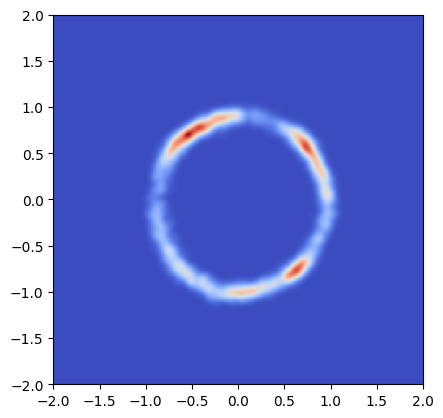

In [15]:
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = lmc_sampler(step_rng, trained_score, dispersion, drift, 2, 5000)
plot_heatmap(samples)

However, if you rerun the NN Training tab one or two more times, the approximation of $\nabla \log \hat{p}_t(x)$ gets better, and the SGM will memorize/overfit and just output training examples again. Therefore, the early stopping is a crucial implicit regularization in SGM training!

## Excercise

Try to implement the latter with the following manifold.

In [16]:
def sample_helix(J: int) -> jax.Array:
    """
    3 dimensional sample
    
    N_samples: Number of samples
    Returns a (N_samples, 3) array of samples
    """
    alphas = jnp.linspace(0, 10, J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    #zs = alphas
    mf = jnp.stack([xs, ys, alphas], axis=1)
    return mf

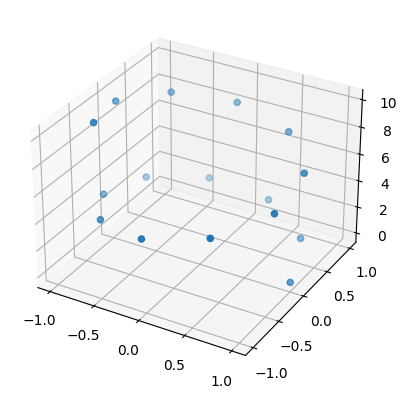

In [50]:
J = 16
mf = sample_helix(J)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(mf[:,0], mf[:,1], mf[:,2])
plt.show()

#### Proposed Solution

In [51]:
def log_hat_pt_helix(x: jax.Array, t: jax.Array) -> Callable[[jax.Array, jax.Array], jax.Array]:
    """
    x: One location in R^n
    t: time (number)
    returns the log density log \hat{p}_t(x) as described above
    
    """
    N = mf.shape[0]
    means = mf * mean_factor(t)
    v = var(t)
    potentials = jnp.sum(-(x - means)**2 / (2 * v), axis=1)
    # this is equivalent to
    # return jnp.log(1/N * jnp.sum(jnp.exp(potentials)))
    # but is numerically more stable
    return logsumexp(potentials, axis=0, b=1/N)

nabla_log_hat_pt_helix = jit(vmap(grad(log_hat_pt_helix), in_axes=(0, 0), out_axes=(0)))

In [52]:
def plot_score_3d(score: Callable[[jax.Array], jax.Array],
               t: jax.Array, area_min: Union[int,float]=-1,
               area_max: Union[int,float]=1) -> None:
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y, z = jnp.meshgrid(x, x, x)
        grid = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    ax = plt.figure().add_subplot(projection='3d')
    ax.quiver(grid[:, 0], grid[:, 1], grid[:, 2], scores[:, 0], scores[:, 1], scores[:, 2], length=0.5, normalize=True)
    plt.show()

We plot the score and we see (although it is hard given that is in 3d) it looks that the arrows go towards the helix.

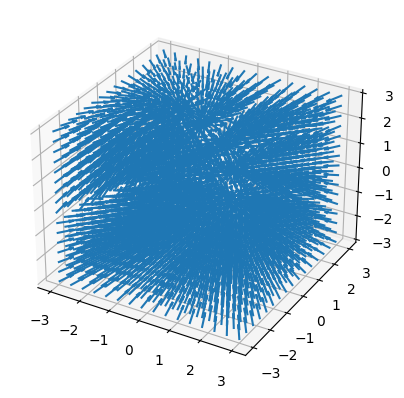

In [53]:
plot_score_3d(nabla_log_hat_pt_helix, 0.01, -3, 3)

In [54]:
def plot_scatters_3d(positions: jax.Array,
                 area_min: Union[int, float]=-2,
                 area_max: Union[int, float]=2) -> None:
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate
    
    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y, z = jnp.meshgrid(a, a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    extent = [area_min, area_max, area_max, area_min]
    plt.imshow(hm, cmap="coolwarm",interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()

In [55]:
rng, step_rng = random.split(rng)
samples = lmc_sampler(step_rng, nabla_log_hat_pt, dispersion, drift, 3, 5000)
#plot_heatmap(samples[:, [0,1]], -3, 3)

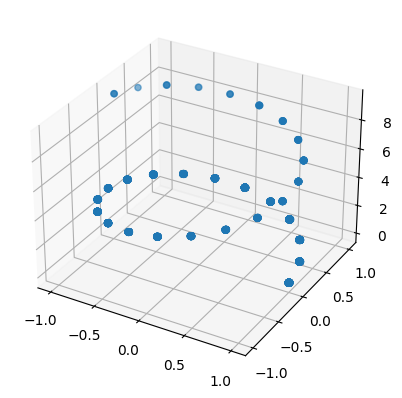

In [56]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(samples[:,0], samples[:,1], samples[:,2])
plt.show()


Now, let's ask the NN to do it.

In [60]:
import optax

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros(3*batch_size).reshape((batch_size, 3))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model_helix = ApproximateScore()
params = score_model.init(rng, x, time)

#Initialize the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

In [61]:
N_epochs = 10_000
train_size = mf.shape[0]
batch_size = 5
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size
for k in range(N_epochs):
    rng, step_rng = random.split(rng)
    perms = jax.random.permutation(step_rng, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    losses = []
    for perm in perms:
        batch = mf[perm, :]
        rng, step_rng = random.split(rng)
        loss, params, opt_state = update_step(params, step_rng, batch, opt_state, score_model_helix)
        losses.append(loss)
    mean_loss = jnp.mean(jnp.array(losses))
    if k % 1000 == 0:
        print("Epoch %d \t, Loss %f " % (k, mean_loss))

Epoch 0 	, Loss 1.066110 
Epoch 1000 	, Loss 0.586744 
Epoch 2000 	, Loss 0.732721 
Epoch 3000 	, Loss 0.471266 
Epoch 4000 	, Loss 0.379101 
Epoch 5000 	, Loss 0.429975 
Epoch 6000 	, Loss 0.546888 
Epoch 7000 	, Loss 0.432864 
Epoch 8000 	, Loss 0.328406 
Epoch 9000 	, Loss 0.325952 


In [62]:
trained_score_helix = lambda x, t: score_model_helix.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = lmc_sampler(step_rng, trained_score, dispersion, drift, 3, 5000)

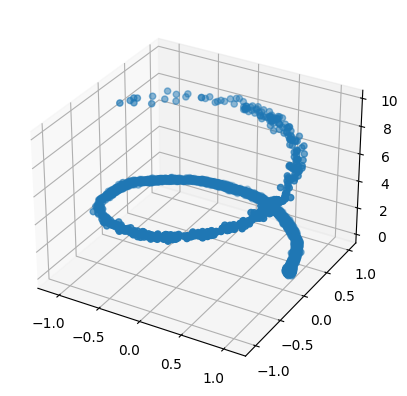

In [63]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(samples[:,0], samples[:,1], samples[:,2])
plt.show()